<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219
Primer semestre - 2024


## Taller 6

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1:** Andrés Felipe Aristizábal Miranda - 202416947

**Integrante 2:**

**NOTA:**  El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller6.ipynb

In [1]:
!pip install -q yfinance

## Objetivo: Predecir los próximos valores de cierre de stocks de compañías, dado el registro histórico de estas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Para leer los datos de Yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# para settear tiempos
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

## Dataset: Para este problema usaremos la librería yfinance, la cual retorna los valores de stock para diferentes empresas, en este caso tenemos los valores de APPLE - AAPL, GOOGLE - GOOG, Microsoft _ MSFT, Amazon - AMZN

Como ejemplo solamente usamos los registros de 1 año, para el taller cambiar el codigo para ver los registros de los ultimos **3 años**

In [3]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

#Asignamos el rango de fechas en las que queremos consultar los datos
end = datetime.now() #fecha actual
start = datetime(end.year - 3, end.month, end.day) #Fecha de hace un año

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-04-08,186.899994,187.289993,184.809998,185.190002,185.190002,39221300,AMAZON
2024-04-09,187.240005,187.339996,184.199997,185.669998,185.669998,36546900,AMAZON
2024-04-10,182.770004,186.270004,182.669998,185.949997,185.949997,35879200,AMAZON
2024-04-11,186.740005,189.770004,185.509995,189.050003,189.050003,40020700,AMAZON
2024-04-12,187.720001,188.380005,185.080002,186.130005,186.130005,38554300,AMAZON
2024-04-15,187.429993,188.690002,183.000000,183.619995,183.619995,48052400,AMAZON
2024-04-16,183.270004,184.830002,182.259995,183.320007,183.320007,32891300,AMAZON
2024-04-17,184.309998,184.570007,179.820007,181.279999,181.279999,31359700,AMAZON
2024-04-18,181.470001,182.389999,178.649994,179.220001,179.220001,30723800,AMAZON


# Seleccionar los datos de una de las compañías previamente ejecutadas y obtener los valores de stock de cierre (Close o Adj close)

In [6]:
google_close_data = df[df['company_name'] == 'GOOGLE']['Adj Close']

print(google_close_data.tail(10))

Date
2024-04-08    156.139999
2024-04-09    158.139999
2024-04-10    157.660004
2024-04-11    160.789993
2024-04-12    159.190002
2024-04-15    156.330002
2024-04-16    156.000000
2024-04-17    156.880005
2024-04-18    157.460007
2024-04-19    155.720001
Name: Adj Close, dtype: float64


In [25]:
test_dates = df[df['company_name'] == 'GOOGLE'].index[-num_test_samples:]

## Graficar la variación de los precios de salida a lo largo del tiempo seleccionado

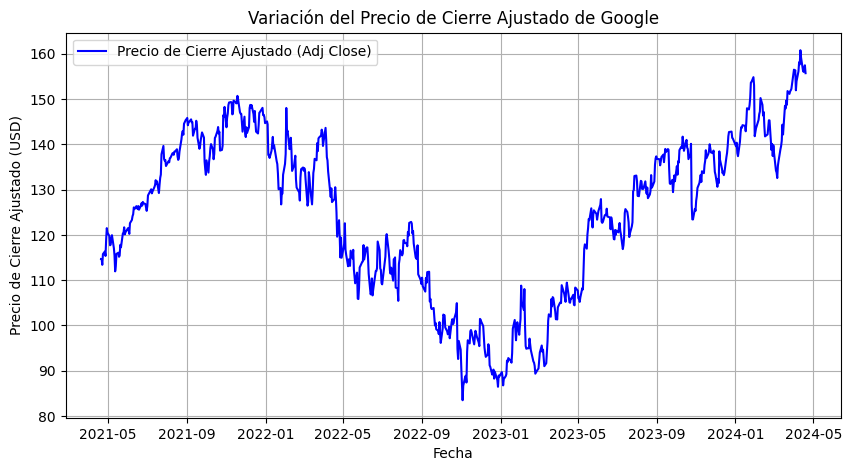

In [7]:
# Graficar la variación de los precios ajustados al cierre
plt.figure(figsize=(10, 5))  # Tamaño del gráfico
plt.plot(google_close_data.index, google_close_data, label='Precio de Cierre Ajustado (Adj Close)', color='blue')
plt.title('Variación del Precio de Cierre Ajustado de Google')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Tomar el 60% de los datos para entrenar 20% para validación y 20% para test

In [8]:
raw_data = df[df['company_name'] == 'GOOGLE']['Adj Close'].values               # Nota: usar .value para convertirlo en un array de numpy
num_train_samples = int(0.6 * len(raw_data))                                    #60% de los datos
num_val_samples = int(0.2 * len(raw_data))                                      #20% de los datos
num_test_samples = len(raw_data) - num_train_samples - num_val_samples          # Los datos restantes
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 453
num_val_samples: 151
num_test_samples: 152


In [9]:
# Estandarizacion de los datos. primero restamos los valores por la media y luego se dividen por
# la desviación estandar
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Dividir los datos en X y Y.
Aquí realizamos en ejemplo con el entrenamiento. **Elaborar los datos para el test y validación**

In [10]:
# dividir los en x_train y y_train
train_data = raw_data[:num_train_samples]
valid_data = raw_data[:num_val_samples]
test_data = raw_data[:num_test_samples]

# Verificar dimensiones
print(f"train shape: {train_data.shape}")
print(f"x_valid shape: {valid_data.shape}")
print(f"x_test shape: {test_data.shape}")

train shape: (453,)
x_valid shape: (151,)
x_test shape: (152,)


Para crear nuestro dataset de entrenamiento, prueba y validación usaremos la función 'timeseries_dataset_from_array'.

La idea general es que al proporcionar una matriz de datos de series temporales (el argumento de datos), timeseries_dataset_from_array
te da ventanas extraídas de la serie temporal original.

Por ejemplo, supomgamos que nuestros datos son: [0 1 2 3 4 5 6] y sequence_length=3, entonces timeseries_dataset_from_array generará las siguientes muestras: [0 1 2], [2 3 4], [3 4 5], [4 5 6].

Usaremos la función timeseries_dataset_from_array para inicializar tres datasets: uno para entrenamiento, otro para prueba y otro para validación:


* sequence_length : Longitud de las secuencias de salida (en número de pasos de tiempo).


Documentación: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array


In [11]:
import numpy as np
from tensorflow import keras

batch_size = 4
sequence_length = 60

# Dataset de entrenamiento
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=train_data[:-sequence_length],
    targets=train_data[sequence_length:],
    sequence_length=sequence_length,
    sequence_stride=1,                                                          # Esto determina el salto entre dos secuencias sucesivas
    sampling_rate=1,                                                            # Esto determina el rate en el que se toman puntos de la secuencia
    batch_size=batch_size,
    shuffle=True
)

# Dataset de validación
validation_dataset = keras.utils.timeseries_dataset_from_array(
    data=valid_data[:-sequence_length],
    targets=valid_data[sequence_length:],
    sequence_length=sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False
)

# Dataset de prueba
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=test_data[:-sequence_length],
    targets=test_data[sequence_length:],
    sequence_length=sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
for dataset in [train_dataset, validation_dataset, test_dataset]:
    for samples, target in dataset.take(1):                                     # Tomamos solo el primer batch para inspección
        print(f'sample shape: {samples.shape}, target shape: {target.shape}')

sample shape: (4, 60), target shape: (4,)
sample shape: (4, 60), target shape: (4,)
sample shape: (4, 60), target shape: (4,)


# Crear Modelo

In [13]:
# Definición de la entrada
inputs = Input(shape=(60, 1))                                                   # 60 timesteps, cada uno con 1 feature

# Agregando la capa LSTM
x = LSTM(128)(inputs)                                                           # 128 unidades en la capa LSTM

# Capa de salida
outputs = Dense(1)(x)                                                           # Una única salida

# Creación del modelo
model = Model(inputs, outputs)

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')                                     # Usando Adam como optimizador y MSE como función de pérdida

# Mostrando el resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Configurar Early Stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',                                                         # Monitorea el 'val_loss' (pérdida de validación)
    patience=10,                                                                # Número de épocas sin mejora después de las cuales el entrenamiento se detendrá
    verbose=1,                                                                  # Muestra mensajes cuando el entrenamiento se detiene
    restore_best_weights=True                                                   # Restaura los pesos del modelo desde la época con el mejor valor de 'val_loss'
)

In [15]:
# Entrenamiento del modelo
history = model.fit(
    train_dataset,                                                              # Dataset de entrenamiento
    epochs=50,                                                                  # Número de épocas para entrenar el modelo
    validation_data=validation_dataset,                                         # Opcional: proporcionar el dataset de validación
    verbose=1                                                                   # Muestra una barra de progreso y mensajes de entrenamiento
)

Epoch 1/50
84/84 [==============================] - 11s 77ms/step - loss: 0.1312 - val_loss: 0.0348
Epoch 2/50
84/84 [==============================] - 5s 63ms/step - loss: 0.0579 - val_loss: 0.0312
Epoch 3/50
84/84 [==============================] - 3s 30ms/step - loss: 0.0489 - val_loss: 0.0252
Epoch 4/50
84/84 [==============================] - 3s 30ms/step - loss: 0.0420 - val_loss: 0.0242
Epoch 5/50
84/84 [==============================] - 4s 44ms/step - loss: 0.0394 - val_loss: 0.0123
Epoch 6/50
84/84 [==============================] - 3s 31ms/step - loss: 0.0352 - val_loss: 0.0201
Epoch 7/50
84/84 [==============================] - 3s 29ms/step - loss: 0.0338 - val_loss: 0.0205
Epoch 8/50
84/84 [==============================] - 3s 30ms/step - loss: 0.0312 - val_loss: 0.0227
Epoch 9/50
84/84 [==============================] - 3s 37ms/step - loss: 0.0298 - val_loss: 0.0122
Epoch 10/50
84/84 [==============================] - 3s 30ms/step - loss: 0.0287 - val_loss: 0.0112
Epoch 11

# Evaluación del modelo

In [16]:
# Recolectar las etiquetas y predicciones
y_true = []
predictions = []

for batch in test_dataset:
    features, labels = batch
    preds = model.predict(features)
    predictions.extend(preds.flatten())  # Aplanar las predicciones si son multidimensionales
    y_true.extend(labels.numpy().flatten())  # Asegurarse de convertir a numpy y aplanar

# Convertir a arrays de numpy para cálculo de métricas
y_true = np.array(y_true)
test_predictions = np.array(predictions)

mse = mean_squared_error(y_true, predictions)
print(f'El error cuadrático medio (MSE) en el conjunto de prueba es: {mse}')

1/1 [==============================] - 0s 29ms/step
El error cuadrático medio (MSE) en el conjunto de prueba es: 0.009420454183316834


## Graficar resultados

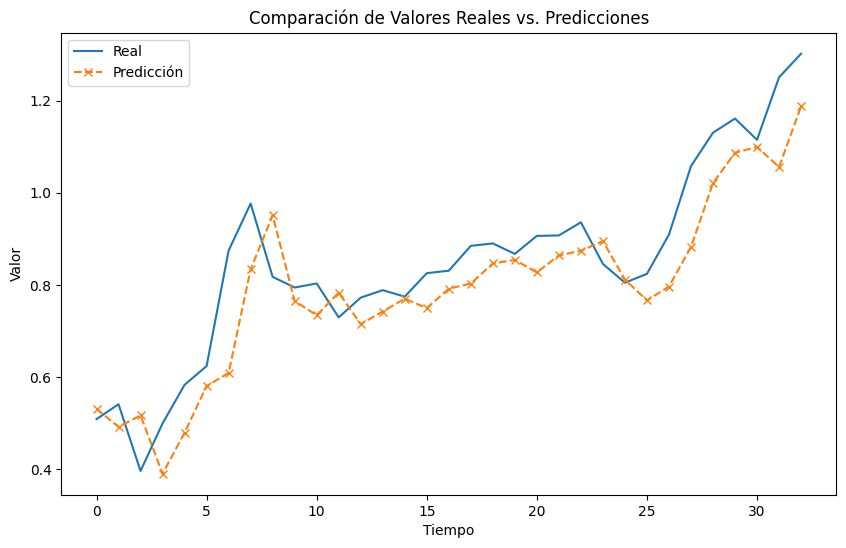

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Real')
plt.plot(test_predictions, label='Predicción', linestyle='--', marker='x')
plt.title('Comparación de Valores Reales vs. Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()